In [1]:
import requests
import lxml.html as lh
import bs4 as bs
import urllib.request
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

In [2]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
import requests
from pandas.io.json import json_normalize 

# Defining the dataset for the neighbourhoods

In [4]:
url ='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
res = requests.get(url)
soup = bs.BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
data = pd.read_json(df[0].to_json(orient='records'))

In [5]:
data.head()

,Borough,Neighbourhood,Postcode
0,Not assigned,Not assigned,M1A
1,Not assigned,Not assigned,M2A
2,North York,Parkwoods,M3A
3,North York,Victoria Village,M4A
4,Downtown Toronto,Harbourfront,M5A


In [6]:
data = data[data['Borough'] != 'Not assigned']

In [7]:
data = data.groupby(['Borough', 'Postcode'], as_index=False).agg(','.join)

In [8]:
data.head()

,Borough,Postcode,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,North Toronto West
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park,Summerhill East"


In [9]:
data['Neighbourhood'] = np.where(data['Neighbourhood'] == 'Not assigned', data['Borough'], data['Neighbourhood'])

In [10]:
data.shape

(103, 3)

In [11]:
geospatial_url = "https://cocl.us/Geospatial_data"
geodata = pd.read_csv(geospatial_url)

In [12]:
geodata.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
geodata.columns = ['Postcode', 'Latitude', 'Longitude']

In [14]:
all_data = pd.merge(data, geodata, on='Postcode')

In [15]:
all_data.head()

,Borough,Postcode,Neighbourhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park,Summerhill East",43.689574,-79.383160


In [16]:
print('The dataframe has {} boroughs and {} neighbourhoods.'.format(
        len(all_data['Borough'].unique()),
        all_data.shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighbourhoods.


In [17]:
all_data['Coordinates'] = list(zip(all_data['Latitude'], all_data['Longitude']))

In [18]:
all_data.head()

,Borough,Postcode,Neighbourhood,Latitude,Longitude,Coordinates
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,"(43.7280205, -79.3887901)"
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,"(43.7127511, -79.3901975)"
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,"(43.7153834, -79.40567840000001)"
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,"(43.7043244, -79.3887901)"
4,Central Toronto,M4T,"Moore Park,Summerhill East",43.689574,-79.383160,"(43.6895743, -79.38315990000001)"


In [19]:
from geopy.geocoders import Nominatim

In [20]:
all_data.head()

,Borough,Postcode,Neighbourhood,Latitude,Longitude,Coordinates
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,"(43.7280205, -79.3887901)"
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,"(43.7127511, -79.3901975)"
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,"(43.7153834, -79.40567840000001)"
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,"(43.7043244, -79.3887901)"
4,Central Toronto,M4T,"Moore Park,Summerhill East",43.689574,-79.383160,"(43.6895743, -79.38315990000001)"


In [21]:
all_data.dtypes

Borough           object
Postcode          object
Neighbourhood     object
Latitude         float64
Longitude        float64
Coordinates       object
dtype: object

# Creating Toronto map and adding neighbourhoods markers on it

In [22]:
to_latitude = 43.651070
to_longitude = -79.347015
map_toronto = folium.Map(location=[to_latitude, to_longitude], zoom_start=11)
map_toronto

In [23]:
for lat, lng, label in zip(all_data['Latitude'], all_data['Longitude'], all_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# Request for finding the venues in Foursquare

In [24]:
search_query = 'Bank'

In [25]:
CLIENT_ID = 'VLUV4U1XCOIIQ5QRWWIC1CXARC1CXT1IWBDPCZ1GV0SG2LD3'
CLIENT_SECRET = '0G4GCA3KQGJ141H4HNPGNFMQMK0SFS4OLJUYONWSL0UI0YDJ'
latitude = all_data.loc[1,'Latitude']
longitude = all_data.loc[1,'Longitude']
radius = 700
VERSION = '20180605'
LIMIT = 100

Firstly I test the dataset

In [26]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=VLUV4U1XCOIIQ5QRWWIC1CXARC1CXT1IWBDPCZ1GV0SG2LD3&client_secret=0G4GCA3KQGJ141H4HNPGNFMQMK0SFS4OLJUYONWSL0UI0YDJ&ll=43.7127511,-79.3901975&v=20180605&query=Bank&radius=700&limit=100'

In [27]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e41b0aca2e538001ba80a98'},
 'response': {'venues': [{'id': '4b310f84f964a52062ff24e3',
    'name': 'BMO Bank of Montreal',
    'location': {'address': '2444 Yonge St.',
     'crossStreet': 'at Roselawn Ave.',
     'lat': 43.710695669191686,
     'lng': -79.39943790435791,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.710695669191686,
       'lng': -79.39943790435791}],
     'distance': 777,
     'postalCode': 'M4P 2H4',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['2444 Yonge St. (at Roselawn Ave.)',
      'Toronto ON M4P 2H4',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d10a951735',
      'name': 'Bank',
      'pluralName': 'Banks',
      'shortName': 'Bank',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/financial_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1581363494',
    'hasPerk': False},
  

It works, so I'll define a function to get the venues from all the neighbourhoods

In [28]:
def getAllVenues(names, latitudes, longitudes, radius=7500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            search_query,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    toronto_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    toronto_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(toronto_venues)

In [29]:
toronto_venues = getAllVenues(names=all_data['Neighbourhood'],
                                   latitudes=all_data['Latitude'],
                                   longitudes=all_data['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Queen's Park
The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Business Reply Mail Processing Centre 969 Eastern
Woodbine Gardens,Parkview Hill
Woodbine Heights
Leaside
Thorncliffe Park
East Toronto
Humber

In [30]:
toronto_venues.tail() #I use the tail method because when dropping duplicates, Python keeps the first row of the duplicate value, so this way I can see if the drop method was applied correctly

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
9930,Weston,43.706876,-79.518188,Money Mart,43.653446,-79.573033,Bank
9931,Weston,43.706876,-79.518188,Banque Nationale,43.736780,-79.435840,Bank
9932,Weston,43.706876,-79.518188,Money Mart,43.679980,-79.433833,Bank
9933,Weston,43.706876,-79.518188,Scotiabank,43.700848,-79.425763,Bank
9934,Weston,43.706876,-79.518188,BMO Bank of Montreal,43.771601,-79.542680,Bank


In [31]:
toronto_venues.shape

(9935, 7)

In [32]:
toronto_venues.drop_duplicates(subset = 'Venue Latitude', inplace = True)

In [33]:
toronto_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
8677,"Agincourt North,L'Amoreaux East,Milliken,Steel...",43.815252,-79.284577,RBC Royal Bank,43.857786,-79.323593,Bank
8772,L'Amoreaux West,43.799525,-79.318389,HSBC,43.853679,-79.338301,Bank
8774,L'Amoreaux West,43.799525,-79.318389,OMJ Mortgage Capital Inc,43.854096,-79.337509,Bank
8805,Upper Rouge,43.836125,-79.205636,TD Canada Trust,43.896614,-79.238740,Bank
8819,Upper Rouge,43.836125,-79.205636,Scotiabank,43.877866,-79.260797,Bank


In [34]:
toronto_venues.shape

(801, 7)

In [35]:
map_toronto_venues = folium.Map(location=[to_latitude, to_longitude], zoom_start=11)

In [36]:
for lat, lng, label in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_venues)  
    
map_toronto_venues

In [37]:
for lat, lng, label in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2.5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Looks like the city center is very saturated, let's look at how many businesses there are per neighbourhood

# Businesses per neighbourhood

In [38]:
per_hood = toronto_venues[['Neighborhood','Venue']] 

In [39]:
per_hood.head()

,Neighborhood,Venue
0,Lawrence Park,RBC Royal Bank
1,Lawrence Park,TD Canada Trust
2,Lawrence Park,TD Canada Trust
3,Lawrence Park,TD Canada Trust
4,Lawrence Park,TD Canada Trust


In [40]:
count_hood = per_hood.groupby(by='Neighborhood', as_index=False).agg({'Venue': pd.Series.nunique})

In [41]:
count_hood = count_hood.rename(columns={'Venue': 'Number of Venues'})

In [42]:
count_hood.head()

,Neighborhood,Number of Venues
0,Agincourt,3
1,"Agincourt North,L'Amoreaux East,Milliken,Steel...",6
2,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",12
3,"Alderwood,Long Branch",9
4,"Bathurst Manor,Downsview North,Wilson Heights",4


In [43]:
count_hood.shape

(61, 2)

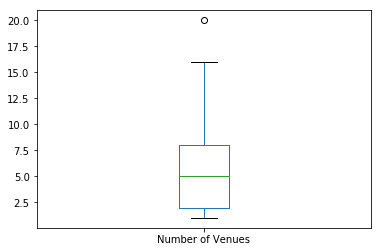

In [44]:
count_hood.plot(
    kind = 'box',
    x = 'Neighborhood',
    y = 'Number of Venues'
)

In [45]:
count_hood.describe()

,Number of Venues
count,61.000000
mean,5.557377
std,4.275997
min,1.000000
25%,2.000000
50%,5.000000
75%,8.000000
max,20.000000


In [46]:
target = int(count_hood['Number of Venues'].mean())
target

5

In [47]:
target_hoods = count_hood[count_hood['Number of Venues'] == target]
target_hoods

,Neighborhood,Number of Venues
16,"Clairlea,Golden Mile,Oakridge",5
20,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",5
23,Downsview West,5
24,"Downsview,North Park,Upwood Park",5
45,Rosedale,5
59,Woburn,5
60,"Woodbine Gardens,Parkview Hill",5


In [48]:
loc_data = all_data.set_index('Neighbourhood')
loc_data.head()

,Borough,Postcode,Latitude,Longitude,Coordinates
Neighbourhood,,,,,
Lawrence Park,Central Toronto,M4N,43.728020,-79.388790,"(43.7280205, -79.3887901)"
Davisville North,Central Toronto,M4P,43.712751,-79.390197,"(43.7127511, -79.3901975)"
North Toronto West,Central Toronto,M4R,43.715383,-79.405678,"(43.7153834, -79.40567840000001)"
Davisville,Central Toronto,M4S,43.704324,-79.388790,"(43.7043244, -79.3887901)"
"Moore Park,Summerhill East",Central Toronto,M4T,43.689574,-79.383160,"(43.6895743, -79.38315990000001)"


In [49]:
loc_data = loc_data.loc[target_hoods['Neighborhood']]
loc_data = loc_data.reset_index('Neighbourhood')

In [50]:
loc_data

,Neighbourhood,Borough,Postcode,Latitude,Longitude,Coordinates
0,"Clairlea,Golden Mile,Oakridge",Scarborough,M1L,43.711112,-79.284577,"(43.711111700000004, -79.2845772)"
1,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",Central Toronto,M4V,43.686412,-79.400049,"(43.68641229999999, -79.4000493)"
2,Downsview West,North York,M3L,43.739015,-79.506944,"(43.7390146, -79.5069436)"
3,"Downsview,North Park,Upwood Park",North York,M6L,43.713756,-79.490074,"(43.713756200000006, -79.4900738)"
4,Rosedale,Downtown Toronto,M4W,43.679563,-79.377529,"(43.6795626, -79.37752940000001)"
5,Woburn,Scarborough,M1G,43.770992,-79.216917,"(43.7709921, -79.21691740000001)"
6,"Woodbine Gardens,Parkview Hill",East York,M4B,43.706397,-79.309937,"(43.7063972, -79.309937)"


In [51]:
loc_data['Neighbourhood']

0                        Clairlea,Golden Mile,Oakridge
1    Deer Park,Forest Hill SE,Rathnelly,South Hill,...
2                                       Downsview West
3                     Downsview,North Park,Upwood Park
4                                             Rosedale
5                                               Woburn
6                       Woodbine Gardens,Parkview Hill
Name: Neighbourhood, dtype: object

In [52]:
map_toronto_targets = folium.Map(location=[to_latitude, to_longitude], zoom_start=11)

In [53]:
for lat, lng, label in zip(loc_data['Latitude'], loc_data['Longitude'], loc_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=20,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.2,
        parse_html=False).add_to(map_toronto_targets)  
    
map_toronto_targets

# Main competitors

In [54]:
business= toronto_venues[['Neighborhood','Venue']] 

In [55]:
count_bus = per_hood.groupby(by='Venue', as_index=False).agg({'Neighborhood': pd.Series.nunique})

In [56]:
count_bus = count_bus.rename(columns={'Neighborhood': 'Count'})

In [57]:
count_bus.tail()

,Venue,Count
73,TSX Toronto Stock Exchange,1
74,Tangerine,1
75,Tangerine Café,2
76,Wall Street Finance,1
77,Western Union @ Money Mart,1


In [58]:
count_bus.shape

(78, 2)

In [59]:
count_bus.describe()

,Count
count,78.000000
mean,4.346154
std,8.754705
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,36.000000


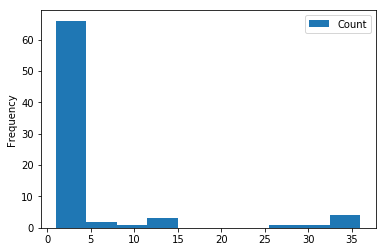

In [60]:
count_bus.plot(
    kind = 'hist',
    x = 'Venue',
    y = 'Count'
)

In [61]:
count_bus.max()

Venue    Western Union @ Money Mart
Count                            36
dtype: object